In [3]:
#testing out the window gen function for ts in LSTM
import numpy as np
from numpy import fft
import pandas as pd
from scipy import signal as sig
from cmath import phase
import math
# from window_generator import WindowGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
# NYC taxi dataset
train_df = pd.read_csv('../sample-data/train/train.csv')
test_df = pd.read_csv('../sample-data/test/test.csv')

Data fields:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [5]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.store_and_fwd_flag = train_df.store_and_fwd_flag.apply(lambda x: 1 if x=='Y' else 0)

In [7]:
class WindowGeneratorNB():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
            ])

In [8]:
ts_train = train_df.groupby(pd.Grouper(key='pickup_datetime', freq='T'))[['passenger_count','trip_duration']].sum().reset_index()
ts_train['time_min'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()/60
ts_train['time_sec'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()
ts_train

,pickup_datetime,passenger_count,trip_duration,time_min,time_sec
0,2016-01-01 00:00:00,6,2143,0.0,0.0
1,2016-01-01 00:01:00,11,3454,1.0,60.0
2,2016-01-01 00:02:00,2,1755,2.0,120.0
3,2016-01-01 00:03:00,3,2417,3.0,180.0
4,2016-01-01 00:04:00,8,1291,4.0,240.0
...,...,...,...,...,...
262075,2016-06-30 23:55:00,16,8370,262075.0,15724500.0
262076,2016-06-30 23:56:00,13,5824,262076.0,15724560.0
262077,2016-06-30 23:57:00,9,6750,262077.0,15724620.0
262078,2016-06-30 23:58:00,10,5893,262078.0,15724680.0


In [9]:
date_time = ts_train.pop('pickup_datetime')

In [ ]:
plot_cols = ['passenger_count','trip_duration']
# one day interval
plot_features = ts_train[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)

# two day interval
plot_features = ts_train[plot_cols][:2880]
plot_features.index = date_time[:2880]
_ = plot_features.plot(subplots=True)

# three day interval
plot_features = ts_train[plot_cols][:4320]
plot_features.index = date_time[:4320]
_ = plot_features.plot(subplots=True)

There seems to be a daily periodicity here with dips in early mornings. Can create new features like time of day

In [10]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [11]:
day = 24*60

ts_train['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ts_train['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

Text(0.5, 1.0, 'Time of day signal')

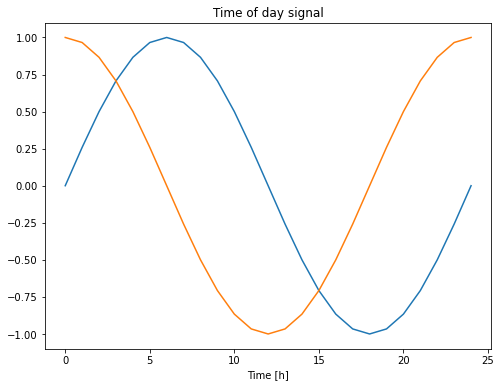

In [12]:
plt.plot(np.array(ts_train['day_sin'])[:25])
plt.plot(np.array(ts_train['day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

<AxesSubplot:xlabel='day_sin'>

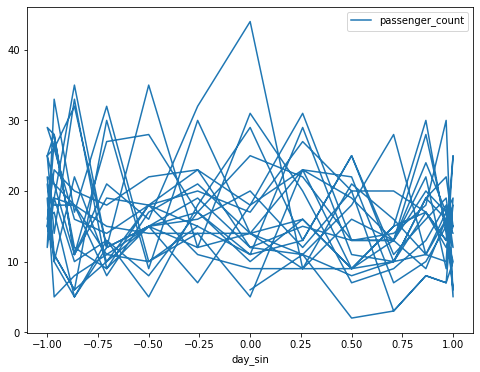

In [13]:
ts_train[:4*60].plot(x='day_sin', y='passenger_count')
# all over the place

In [14]:
# to determine which frequencies are important, use FFT
# import tensorflow as tf
# import seaborn as sns

In [15]:
# from scipy import fft
# from scipy import signal as sig
# fftS = fft.fft(ts_train['passenger_count'])
# powerS = np.abs(fftS)
# freqS = fft.fftfreq(len(ts_train['passenger_count']))

In [16]:
# mask = freqS >= 0
# freqS = freqS[mask]
# powerS = powerS[mask]

# plt.figure( figsize=(10, 4) )

# ax1 = plt.subplot( 1, 2, 1 )
# ax1.plot(freqS, powerS, label='signal')
# ax1.set_title('All Frequencies')
# ax1.set_ylabel( 'Amplitude' )
# ax1.set_xlabel( 'Frequency [1 / Min]' )
# plt.xticks(rotation=90)

# ax2 = plt.subplot( 1, 2, 2 )
# mask = (freqS > 0) & (freqS <= 0.01)
# ax2.plot(freqS[mask], powerS[mask])
# ax2.set_title('Frequencies in (0, 0.01]')
# ax2.set_ylabel( 'Amplitude' )
# ax2.set_xlabel( 'Frequency [1 / Min]' )
# ax2.set_xlim(0,0.01)

# peaks = sig.find_peaks(powerS[freqS >=0], prominence=10**4)[0]
# peak_freq =  freqS[peaks]
# peak_power = powerS[peaks]
# plt.plot(peak_freq, peak_power, 'ro')

# plt.tight_layout()
# plt.xticks(rotation=90)

In [17]:
# output = pd.DataFrame()
# output['index'] = peaks
# output['freq (1/min)'] = peak_freq
# output['amplitude'] = peak_power
# output['period (days)'] = 1 / peak_freq / 60 / 24
# output['fft'] = fftS[peaks]
# output = output.sort_values('amplitude', ascending=False)

# output

In [13]:
ts_train

,passenger_count,trip_duration,time_min,time_sec,day_sin,day_cos
0,6,2143,0.0,0.0,-2.008887e-10,1.000000
1,11,3454,1.0,60.0,2.588190e-01,0.965926
2,2,1755,2.0,120.0,5.000000e-01,0.866025
3,3,2417,3.0,180.0,7.071068e-01,0.707107
4,8,1291,4.0,240.0,8.660254e-01,0.500000
...,...,...,...,...,...,...
262075,16,8370,262075.0,15724500.0,-9.659258e-01,0.258819
262076,13,5824,262076.0,15724560.0,-8.660254e-01,0.500000
262077,9,6750,262077.0,15724620.0,-7.071068e-01,0.707107
262078,10,5893,262078.0,15724680.0,-5.000000e-01,0.866025


In [14]:
class FFTFeatureExtractor:
    """
    This class creates Fast Fourier Transform variables for time series analysis. Two methods can be used to obtain inverse FFT of the peaks:
    1. decompose_df_into_pure_freq(): decompose FFT into frequencies and amplitudes and phases manually
    2. ifft_transform(): call numpy's IFFT transform on array of freq peaks
    Second method results in much smaller amplitudes of final time-domain signal, while first method helps to visualize each of the different 
    frequencies that make up the signal and the period of cyclicity/seasonality. 
    """
    def __init__(self, series, time_series) -> None:
        """
        Parameters
        ----------
        series : [np.array or list of ints]
            the y-value that needs to be performed FFT on 
        time_series : [np.array or list of datetime64[ns]]
            the x-values of time 
        """
        self.series = series
        self.ts = time_series

    def plotter_T_or_F(self, x, y, label, xlim_max=None, T_or_F='T'):        
        """Plots the time and frequency signatures 

        Parameters
        ----------
        x : [np.array or list of datetime64[ns] or floats]
            Either time values or frequency values can be passed
        y : [np.array or list of floats]
            Either values of series or power of transformed series can be passed
        label : [str]
            Plot title
        xlim_max : [float], optional
            Sets the max limit of the x axis on the graph, by default None
        T_or_F : str, optional
            Time or frequency graph, by default 'T'
        """
        self.label = label
        if T_or_F == 'T':
            plt.plot(x[:xlim_max], y[:xlim_max], label=label)
            plt.title(label)
            plt.ylabel( '{}'.format(label) )
            plt.xlabel( 'Time' )
        else:
            mask = (x > 0) & (x <= xlim_max)
            plt.plot(x[mask], y[mask], label=label)
            plt.title(label)
            plt.ylabel( 'Amplitude' )
            plt.xlabel( 'Frequency (1/Min]' )

            self.peaks = sig.find_peaks(y[x >=0], prominence=10**4)[0]
            self.peak_freq =  x[self.peaks]
            self.peak_power = y[self.peaks]
            plt.plot(self.peak_freq, self.peak_power, 'ro')
            plt.xlim(0,xlim_max)
        plt.xticks(rotation=90)
        plt.tight_layout()

    def fft_transform(self, freqlim_max=0.02, timelim_max=60*24):
        """Creates FFT variables and plots for visualization on the column of interest

        Parameters
        ----------
        freqlim_max : float, optional
            Max limit of the frequency to be shown on x-axis, by default 0.02 1/min
        timelim_max : float, optional
            Max limit of the time to be shown on x-axis, by default 60*24 mins
        """
        self.fftOutput = fft.fft(self.series)
        self.power = np.abs(self.fftOutput)
        self.freq = fft.fftfreq(len(self.series))

        plt.figure(figsize=(14,6))

        ax1 = plt.subplot(2,2,1)
        self.plotter_T_or_F(self.ts, self.series, label='Original Time Signature',T_or_F='T', xlim_max=len(self.ts))
        ax1 = plt.subplot(2,2,2)
        self.plotter_T_or_F(self.ts, self.series, label='Original Time Zoomed to {} days'.format(timelim_max/60/24),T_or_F='T', xlim_max=timelim_max)
        ax2 = plt.subplot(2,2,3)
        self.plotter_T_or_F(self.freq, self.power, label='Transformed Frequency Signature',T_or_F='F', xlim_max=max(self.freq))
        ax3 = plt.subplot(2,2,4)
        self.plotter_T_or_F(self.freq, self.power, label='Transformed Frequency Zoomed to (0, {}]'.format(freqlim_max),T_or_F='F', xlim_max=freqlim_max)

    def frequency_table_viewer(self):
        """Views the frequency table with index of the freq peaks, the freq peaks' values (1/min), the height/amplitude and the corresponding period in days
        generated after running fft_transform() function

        Returns
        -------
        [pd.Dataframe]
            Output dataframe is returned with index, top frequencies, amplitude, period and fft complex values
        """
        output = pd.DataFrame()
        output['index'] = self.peaks
        output['freq (1/min)'] = self.peak_freq
        output['amplitude'] = self.peak_power
        output['period (days)'] = 1 / self.peak_freq / 60 / 24
        output['fft'] = self.fftOutput[self.peaks]
        output = output.sort_values('amplitude', ascending=False)
        self.output = output
        return output

    def fourier_terms_df_creator(self):
        """Creates df fourier_terms with top FFT frequencies (complex notation), freq values (1/min), amplitude and phase; also creates an
        internal dictionary of this dataframe stored as fourier_terms_dict

        Returns
        -------
        [pd.DataFrame]
            Returns dataframe with top FFT frequencies (complex notation), freq values (1/min), amplitude and phase
        """
        fourier_terms = pd.DataFrame()
        fourier_terms['fft'] = self.output['fft']
        fourier_terms['freq (1/min)'] = self.output['freq (1/min)']
        fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
        fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
        fourier_terms.sort_values(by=['amplitude'], ascending=[0])

        # Create some helpful labels (FT_1..FT_N)
        fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))
        
        # Turn our dataframe into a dictionary for easy lookup
        fourier_terms = fourier_terms.set_index('label')
        self.fourier_terms = fourier_terms
        fourier_terms_dict = fourier_terms.to_dict('index')
        self.fourier_terms_dict = fourier_terms_dict
        return fourier_terms

    def decompose_df_into_pure_freq(self, signal, time_min):
        """Creates columnar df with time steps in one column, the actual signal in second column, and the decomposition of the signal into varying
        sign wave values under each column FT_1, FT_2; also included is the sum of all individual values in final column called FT_All

        Parameters
        ----------
        signal : [np.array or list of floats]
            the y-value that needs to be performed FFT on
        time_min : [np.array or list of datetime64[ns]]
            the x-values of time 

        Returns
        -------
        [pd.DataFrame]
            Returns columnar dataframe as mentioned above
        """
        data = pd.DataFrame()
        data['pass_count_standardized'] = signal
        data['time_min'] = time_min
        for key in self.fourier_terms_dict.keys():
            a = self.fourier_terms_dict[key]['amplitude']  
            w = 2 * np.pi * (self.fourier_terms_dict[key]['freq (1/min)'] / 60) # units in 1/s
            p = self.fourier_terms_dict[key]['phase']    
            data[key] = data['time_min'].apply(lambda t: a * math.cos(w*t*60 + p))

        data['FT_All'] = 0
        for column in list(self.fourier_terms.index):
            data['FT_All'] = data['FT_All'] + data[column]
        
        self.pureFreqDF = data
        return data
    
    def ifft_transform(self):
        """Performs the inverse FFT from the np.fft package on the filtered FFT output (np.series of freq indexes with 0's except for those
        indexes where a peak was registered from FFT). 

        Returns
        -------
        [pd.DataFrame]
            Time-domain signature that represents the FT_All combined feature, however the amplitude is much smaller than manual FT_All method
        """
        self.filtered_fft_output = np.array([f if i in list(self.output['index']) else 0 for i, f in enumerate(self.fftOutput)])
        self.filtered_residuals = fft.ifft(self.filtered_fft_output)
        return self.filtered_residuals


In [15]:
from sklearn.linear_model import LinearRegression
# X = pd.DataFrame(ts_train['time_min'])
# y = pd.DataFrame(ts_train['passenger_count'])
# model = LinearRegression()
# model.fit(X,y)

# ts_train['pred_signal_linreg'] = model.predict(X)
# ts_train['residuals'] = ts_train['passenger_count'] - ts_train['pred_signal_linreg']

In [16]:
# plt.plot(ts_train['time_min'], ts_train['pred_signal_linreg'])
# plt.plot(ts_train['time_min'], ts_train['passenger_count'])

In [17]:
# print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
# print('R-squared: {:.2e}'.format(model.score(X,y)))

In [18]:
ts_train

,passenger_count,trip_duration,time_min,time_sec,day_sin,day_cos
0,6,2143,0.0,0.0,-2.008887e-10,1.000000
1,11,3454,1.0,60.0,2.588190e-01,0.965926
2,2,1755,2.0,120.0,5.000000e-01,0.866025
3,3,2417,3.0,180.0,7.071068e-01,0.707107
4,8,1291,4.0,240.0,8.660254e-01,0.500000
...,...,...,...,...,...,...
262075,16,8370,262075.0,15724500.0,-9.659258e-01,0.258819
262076,13,5824,262076.0,15724560.0,-8.660254e-01,0.500000
262077,9,6750,262077.0,15724620.0,-7.071068e-01,0.707107
262078,10,5893,262078.0,15724680.0,-5.000000e-01,0.866025


In [19]:
ts_train['pass_count_standardized'] = (ts_train['passenger_count'] - np.mean(ts_train['passenger_count'])) / np.std(ts_train['passenger_count'])

In [20]:
fftTest = FFTFeatureExtractor(ts_train['pass_count_standardized'], time_series=date_time)

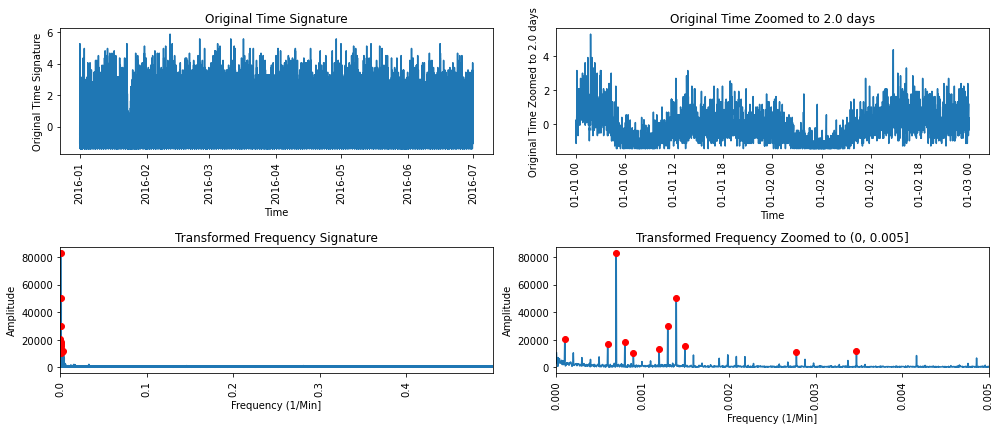

In [21]:
fftTest.fft_transform(freqlim_max=.005, timelim_max=48*60)

In [22]:
x = fftTest.frequency_table_viewer()
x

,index,freq (1/min),amplitude,period (days),fft
2,182,0.000694,83129.120703,1.000000,-19025.269777+80922.739812j
7,364,0.001389,50464.065795,0.500000,20353.750914+46177.340333j
6,338,0.001290,30235.316117,0.538462,25628.566729+16042.160332j
0,26,0.000099,20405.092830,7.000000,18367.142717-8889.087793j
3,208,0.000794,18152.144782,0.875000,11904.160193-13703.697687j
1,156,0.000595,16850.799015,1.166667,7611.043881+15034.009395j
8,390,0.001488,15177.829631,0.466667,-13298.138668-7316.147912j
5,312,0.001190,13107.076583,0.583333,-10193.657445+8239.223533j
10,910,0.003472,12192.004321,0.200000,3243.886772+11752.538789j
9,728,0.002778,11290.985209,0.250000,-4843.691706-10199.264564j


In [23]:
# def ifft_transform(self):
#     self.filtered_fft_output = np.array([f if i in list(self.output['index']) else 0 for i, f in enumerate(self.fftOutput)])
#     self.filtered_residuals = fft.ifft(self.filtered_fft_output)
#     return self.filtered_residuals

# FFTFeatureExtractor.ifft_transform = ifft_transform

In [62]:
fftTest.fftOutput

array([ 1.29247724e-11   +0.j        , -1.04464289e+04 +394.33691302j,
       -2.61649283e+03+1520.2045388j , ...,
        2.52097771e+03-2439.00561116j, -2.61649283e+03-1520.2045388j ,
       -1.04464289e+04 -394.33691302j])

In [57]:
fftTest.filtered_fft_output[fftTest.filtered_fft_output < 0]

array([-19025.26977686+80922.73981226j,  -8516.36902411 -6249.00244892j,
       -10193.65744545 +8239.22353329j, -13298.13866828 -7316.14791183j,
        -4843.69170562-10199.26456372j])

In [24]:
filtered_residuals = fftTest.ifft_transform()

In [27]:
len(filtered_residuals)

262080

In [25]:
w=ts_train.join(pd.DataFrame(filtered_residuals.real)).rename(columns={0:'filtered_residuals'})

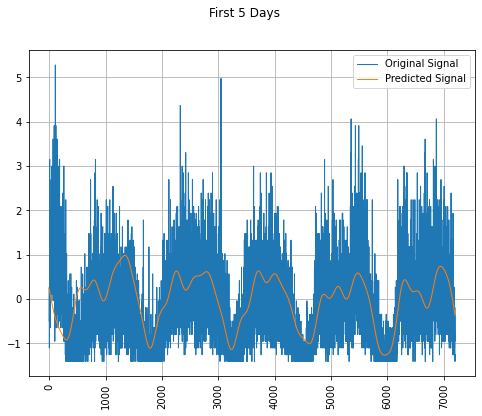

In [26]:
X = w[['time_min','filtered_residuals']]
y = w['pass_count_standardized']

modelNew = LinearRegression()
modelNew.fit(X,y)

y_pred = modelNew.predict(X)

N = 24 * 60 * 5

plt.plot(X['time_min'][:N], y[:N], linewidth=1, label='Original Signal')
plt.plot(X['time_min'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('First {} Days'.format(int(N/24/60)))
plt.grid()
plt.xticks(rotation=90)

print()

Slope: [1.09102476e-07 1.99994384e+00], Intercept: -0.01
R-squared: 3.55e-01



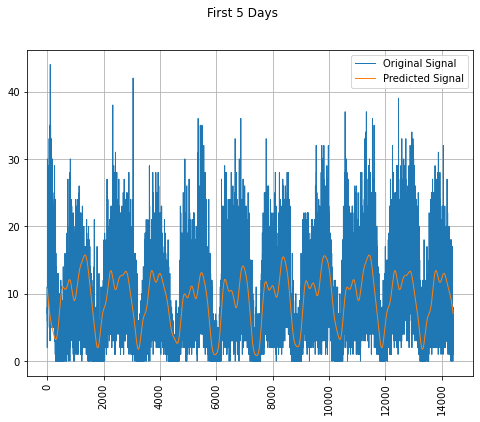

In [27]:
print('Slope: {}, Intercept: {:.2f}'.format(modelNew.coef_, modelNew.intercept_))
print('R-squared: {:.2e}'.format(modelNew.score(X,y)))

# creating it back to actual values based on mean and std of original passenger count
ts_train['pass_count_predicted'] = (y_pred * np.std(ts_train['passenger_count'])) + np.mean(ts_train['passenger_count'])
N = 24 * 60 * 10

plt.plot(ts_train['time_min'][:N], ts_train['passenger_count'][:N], linewidth=1, label='Original Signal')
plt.plot(ts_train['time_min'][:N], ts_train['pass_count_predicted'][:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.xticks(rotation=90)

print()

In [76]:
# ------------------------------------------------------------
# new method using IFFT
# ------------------------------------------------------------

# filtered_fft_output = np.array([f if i in list(x['index']) else 0 for i, f in enumerate(fftTest.fftOutput)])
# filtered_residuals = fft.ifft(filtered_fft_output)
# filtered_residuals_All = fft.ifft(fftTest.fftOutput)

In [77]:
# ------------------------------------------------------------
# new method using IFFT
# ------------------------------------------------------------

# print(filtered_fft_output[:30])
# print(filtered_residuals[:30])

In [28]:
# validation check
fftTest.fourier_terms_df_creator()

,fft,freq (1/min),amplitude,phase
label,,,,
FT_1,-19025.269777+80922.739812j,0.000694,83129.120703,1.801707
FT_2,20353.750914+46177.340333j,0.001389,50464.065795,1.155642
FT_3,25628.566729+16042.160332j,0.001290,30235.316117,0.559281
FT_4,18367.142717-8889.087793j,0.000099,20405.092830,-0.450739
FT_5,11904.160193-13703.697687j,0.000794,18152.144782,-0.855556
FT_6,7611.043881+15034.009395j,0.000595,16850.799015,1.102157
FT_7,-13298.138668-7316.147912j,0.001488,15177.829631,-2.638624
FT_8,-10193.657445+8239.223533j,0.001190,13107.076583,2.461830
FT_9,3243.886772+11752.538789j,0.003472,12192.004321,1.301486


In [29]:
# validation check
decomposedResult = fftTest.decompose_df_into_pure_freq(signal=ts_train['pass_count_standardized'], time_min= ts_train['time_min']  )

In [30]:
decomposedResult.head()

,pass_count_standardized,time_min,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,FT_9,FT_10,FT_11,FT_All
0,-0.495907,0.0,-19025.269777,20353.750914,25628.566729,18367.142717,11904.160193,7611.043881,-13298.138668,-10193.657445,3243.886772,-4843.691706,-8516.369024,31231.424586
1,0.263713,1.0,-19378.179612,19950.007706,25497.732054,18372.680000,11972.347514,7554.763719,-13229.152571,-10255.000952,2986.734532,-4664.952277,-8481.178373,30325.801741
2,-1.103604,2.0,-19730.720514,19544.745228,25365.223113,18378.210145,12040.237123,7498.377884,-13159.009961,-10315.770692,2728.160768,-4484.791859,-8445.720804,29418.940430
3,-0.951680,3.0,-20082.885773,19137.994341,25231.048607,18383.733149,12107.827330,7441.887166,-13087.716972,-10375.963266,2468.288548,-4303.265331,-8409.997432,28510.950368
4,-0.192059,4.0,-20434.668681,18729.786022,25095.217345,18389.249010,12175.116457,7385.292354,-13015.279836,-10435.575306,2207.241556,-4120.427985,-8374.009381,27601.941554


In [31]:
decomposedResult['FT_All_Std'] = (decomposedResult['FT_All'] - np.mean(decomposedResult['FT_All'])) / np.std(decomposedResult['FT_All'])
decomposedResult['pass_count_std-FT_All_Std'] = (decomposedResult['pass_count_standardized'] - decomposedResult['FT_All_Std'])

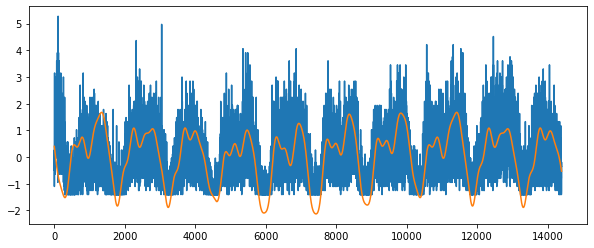

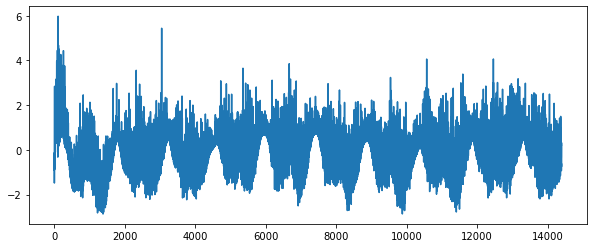

In [32]:
N = 24*60*10
plt.figure(figsize=(10,4))
plt.plot(decomposedResult['time_min'][:N], decomposedResult['pass_count_standardized'][:N] )
plt.plot(decomposedResult['time_min'][:N], decomposedResult['FT_All_Std'][:N] )

plt.figure(figsize=(10,4))
plt.plot(decomposedResult['time_min'][:N], (decomposedResult['pass_count_std-FT_All_Std'])[:N] )


In [33]:
print("Mean and standard deviation of standardized passenger count")
print(np.mean(decomposedResult['pass_count_standardized']), np.std(decomposedResult['pass_count_standardized']))
print("Mean and standard deviation of standardized passenger count subtract standardized total frequency")
print(np.mean(decomposedResult['pass_count_std-FT_All_Std']), np.std(decomposedResult['pass_count_std-FT_All_Std']))

print("Mean and standard deviation of Inverse FTT-transformed peaks of FFT-transformed standardized passenger counts")
print(np.mean(filtered_residuals), np.std(filtered_residuals))

Mean and standard deviation of standardized passenger count
6.159772190350075e-17 1.0000000000000002
Mean and standard deviation of standardized passenger count subtract standardized total frequency
4.771654513651467e-17 0.899111964909852
Mean and standard deviation of Inverse FTT-transformed peaks of FFT-transformed standardized passenger counts
(-1.6809237491272211e-18-1.4098070153970242e-18j) 0.42129339806231575


In [145]:
gold_train_table = decomposedResult.merge(ts_train, left_on=['time_min', 'pass_count_standardized'], right_on=['time_min', 'pass_count_standardized'])
gold_train_table.head()

,pass_count_standardized,time_min,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,...,FT_11,FT_All,FT_All_Std,pass_count_std-FT_All_Std,passenger_count,trip_duration,time_sec,day_sin,day_cos,pass_count_predicted
0,-0.495907,0.0,-19025.269777,20353.750914,25628.566729,18367.142717,11904.160193,7611.043881,-13298.138668,-10193.657445,...,-8516.369024,31231.424586,0.400026,-0.895933,6,2143,0.0,-2.008887e-10,1.000000,10.738808
1,0.263713,1.0,-19378.179612,19950.007706,25497.732054,18372.680000,11972.347514,7554.763719,-13229.152571,-10255.000952,...,-8481.178373,30325.801741,0.388426,-0.124713,11,3454,60.0,2.588190e-01,0.965926,10.693319
2,-1.103604,2.0,-19730.720514,19544.745228,25365.223113,18378.210145,12040.237123,7498.377884,-13159.009961,-10315.770692,...,-8445.720804,29418.940430,0.376811,-1.480415,2,1755,120.0,5.000000e-01,0.866025,10.647769
3,-0.951680,3.0,-20082.885773,19137.994341,25231.048607,18383.733149,12107.827330,7441.887166,-13087.716972,-10375.963266,...,-8409.997432,28510.950368,0.365181,-1.316861,3,2417,180.0,7.071068e-01,0.707107,10.602162
4,-0.192059,4.0,-20434.668681,18729.786022,25095.217345,18389.249010,12175.116457,7385.292354,-13015.279836,-10435.575306,...,-8374.009381,27601.941554,0.353538,-0.545597,8,1291,240.0,8.660254e-01,0.500000,10.556504


In [147]:
train_df = gold_train_table[['time_min','pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration']][:int(0.7*len(decomposedResult))]
val_df = gold_train_table[['time_min','pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration']][int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table[['time_min','pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration']][int(0.85*len(decomposedResult)):]


(0.0, 50000.0)

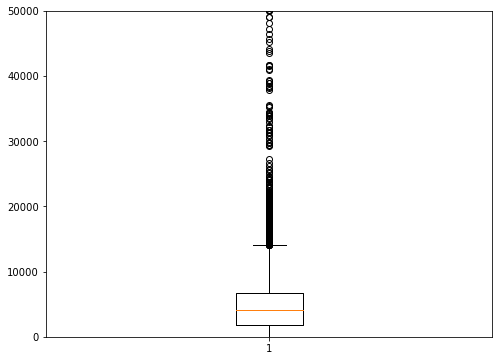

In [167]:
plt.boxplot(train_df.trip_duration.values)
plt.ylim(0,50000)

In [149]:
testWindow = WindowGeneratorNB(input_width=24, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['pass_count_standardized'])
testWindow

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['pass_count_standardized']

In [72]:
import tensorflow as tf

In [69]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGeneratorNB.split_window = split_window

In [73]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:testWindow.total_window_size]),
                           np.array(train_df[100:100+testWindow.total_window_size]),
                           np.array(train_df[200:200+testWindow.total_window_size])])

example_inputs, example_labels = testWindow.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 1)
Inputs shape: (3, 24, 1)
Labels shape: (3, 1, 1)


In [83]:
testWindow.example = example_inputs, example_labels

In [107]:
testWindow.example[1][0,:,0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.87140939])>

In [85]:
def plot(self, model=None, plot_col='pass_count_standardized', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGeneratorNB.plot = plot

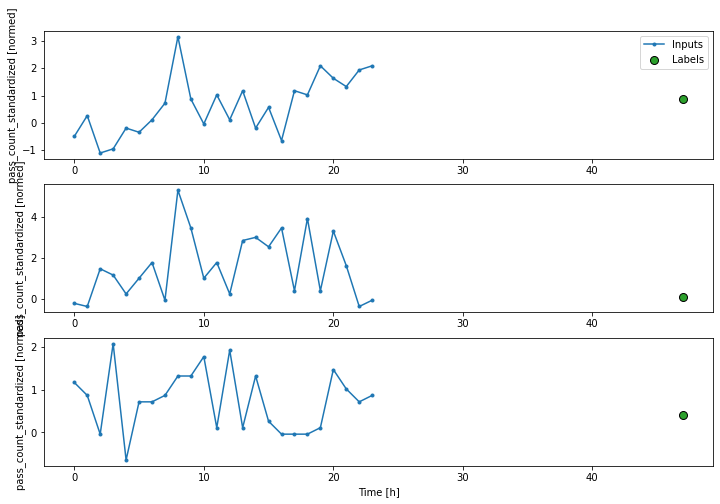

In [86]:
testWindow.plot()

## Create a tf.dataset

In [108]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGeneratorNB.make_dataset = make_dataset

In [109]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGeneratorNB.train = train
WindowGeneratorNB.val = val
WindowGeneratorNB.test = test
WindowGeneratorNB.example = example

In [137]:
testWindow.train.element_spec

(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [138]:
for example_inputs, example_labels in testWindow.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [139]:
single_step_window = WindowGeneratorNB(
    input_width=1, label_width=1, shift=1,
    label_columns=['pass_count_standardized'])
single_step_window

TypeError: __init__() missing 3 required positional arguments: 'train_df', 'val_df', and 'test_df'

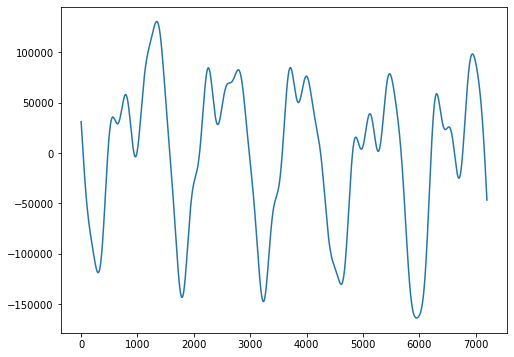

In [67]:
# Check the first Fourier term, which should have a period = 1 day
# plt.plot(decomposedResult['time_min'][:24*5*60], decomposedResult['FT_1'][:24*5*60])
# plt.plot(decomposedResult['time_min'][:24*5*60], decomposedResult['FT_2'][:24*5*60])
# plt.plot(decomposedResult['time_min'][:24*5*60], decomposedResult['FT_1'][:24*5*60] + decomposedResult['FT_2'][:24*5*60])
plt.plot(decomposedResult['time_min'][:24*5*60], decomposedResult['FT_All'][:24*5*60] )

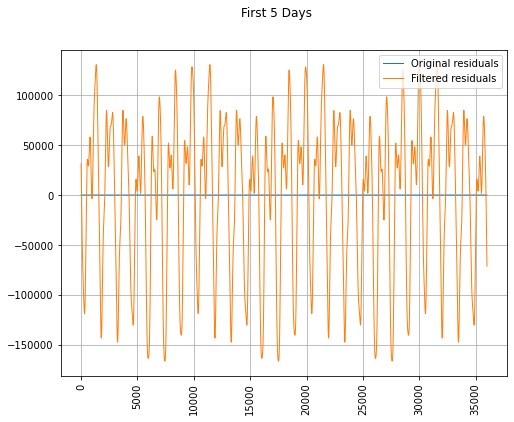

In [35]:
# definitely higher on the amplitude but could be used as a predictor variable for y

N = 24 * 1500
plt.plot(decomposedResult['time_min'][:N], decomposedResult['pass_count_standardized'][:N][:N], linewidth=1, label='Original residuals')
plt.plot(decomposedResult['time_min'][:N], decomposedResult['FT_All'][:N], linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
# plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

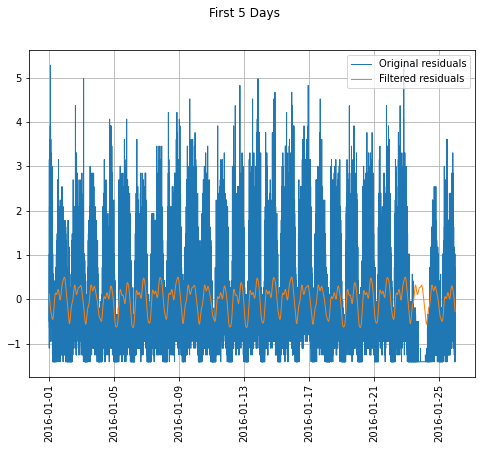

In [36]:
N = 24 * 1500
plt.plot(date_time[:N], ts_train['pass_count_standardized'][:N], linewidth=1, label='Original residuals')
plt.plot(date_time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
# plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [70]:
# pass_count_predicted is based on IFFT on the peaks method
ts_train

,passenger_count,trip_duration,time_min,time_sec,day_sin,day_cos,pass_count_standardized,pass_count_predicted
0,6,2143,0.0,0.0,-2.008887e-10,1.000000,-0.495907,10.738808
1,11,3454,1.0,60.0,2.588190e-01,0.965926,0.263713,10.693319
2,2,1755,2.0,120.0,5.000000e-01,0.866025,-1.103604,10.647769
3,3,2417,3.0,180.0,7.071068e-01,0.707107,-0.951680,10.602162
4,8,1291,4.0,240.0,8.660254e-01,0.500000,-0.192059,10.556504
...,...,...,...,...,...,...,...,...
262075,16,8370,262075.0,15724500.0,-9.659258e-01,0.258819,1.023333,11.153333
262076,13,5824,262076.0,15724560.0,-8.660254e-01,0.500000,0.567561,11.108238
262077,9,6750,262077.0,15724620.0,-7.071068e-01,0.707107,-0.040135,11.063053
262078,10,5893,262078.0,15724680.0,-5.000000e-01,0.866025,0.111789,11.017785


In [ ]:
X = pd.DataFrame(ts_train[['time_min', 'FT_All']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(ts_train['passenger_count']) 

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)


N = 24 * 5 * 60

plt.plot(X['time_min'][:N], y[:N], linewidth=1, label='Original Signal')
plt.plot(X['time_min'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.xticks(rotation=90)

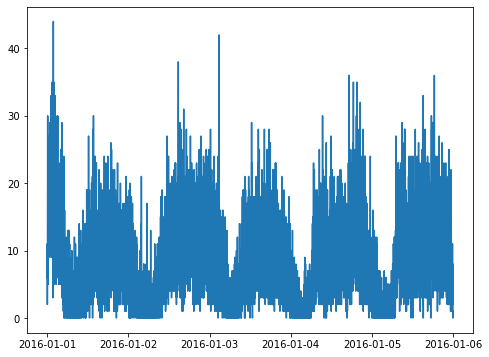

In [230]:
# plt.plot(date_time[:60*24*5], ts_train['FT_All'][:60*24*5])
plt.plot(date_time[:60*24*5], ts_train['passenger_count'][:60*24*5])

In [87]:
fftTripDur = FFTFeatureExtractor(ts_train['trip_duration'], time_series=date_time)

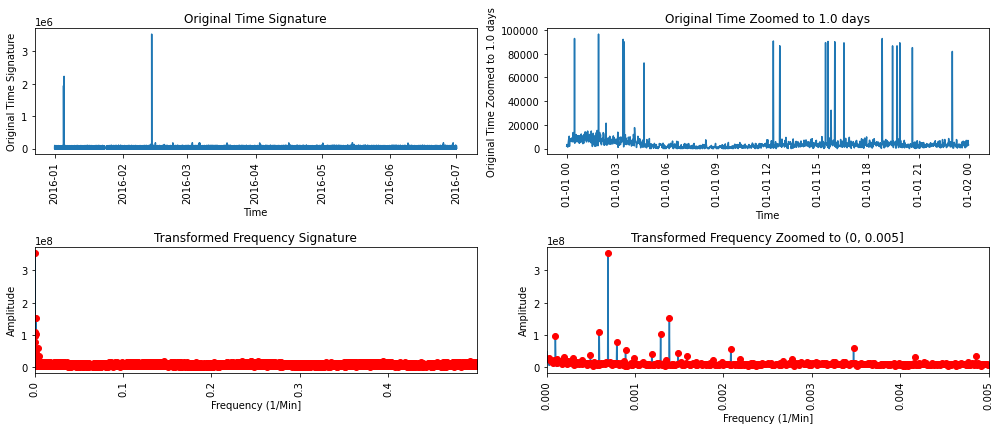

In [89]:
fftTripDur.fft_transform(freqlim_max=0.005)

In [90]:
fftTripDur.frequency_table_viewer()

,index,freq (1/min),amplitude,period (days),fft
56,182,0.000694,3.545730e+08,1.000000,-1.137137e+08+3.358440e+08j
116,364,0.001389,1.531271e+08,0.500000,7.639417e+07+1.327097e+08j
48,156,0.000595,1.109552e+08,1.166667,1.510498e+07+1.099222e+08j
107,338,0.001290,1.038380e+08,0.538462,9.244087e+07+4.729711e+07j
7,26,0.000099,9.860020e+07,7.000000,9.859163e+07+1.300194e+06j
...,...,...,...,...,...
13439,43251,0.165030,1.333858e+06,0.004208,6.543940e+05+1.162302e+06j
15625,49992,0.190751,1.314829e+06,0.003641,7.099125e+05-1.106707e+06j
25232,80886,0.308631,1.302779e+06,0.002250,1.293101e+06+1.585024e+05j
35054,112392,0.428846,1.169591e+06,0.001619,1.106322e+06+3.794655e+05j
